# Getting started

Ontology based atomic structure creation, manipulation, querying.

Imports

In [1]:
from atomrdf import KnowledgeGraph
import atomrdf.build as build

The initial step is to create a Knowledge Graph

In [2]:
kg = KnowledgeGraph(enable_log=True)

## Creation of structures

We will create three structures for the demonstration.

First a BCC Iron structure

In [3]:
struct_Fe = build.bulk("Fe", graph=kg)

Note that we passed an argument `graph=kg` which ensures that when the structure is created, it is also added to the Graph automatically. We can visualise the graph.

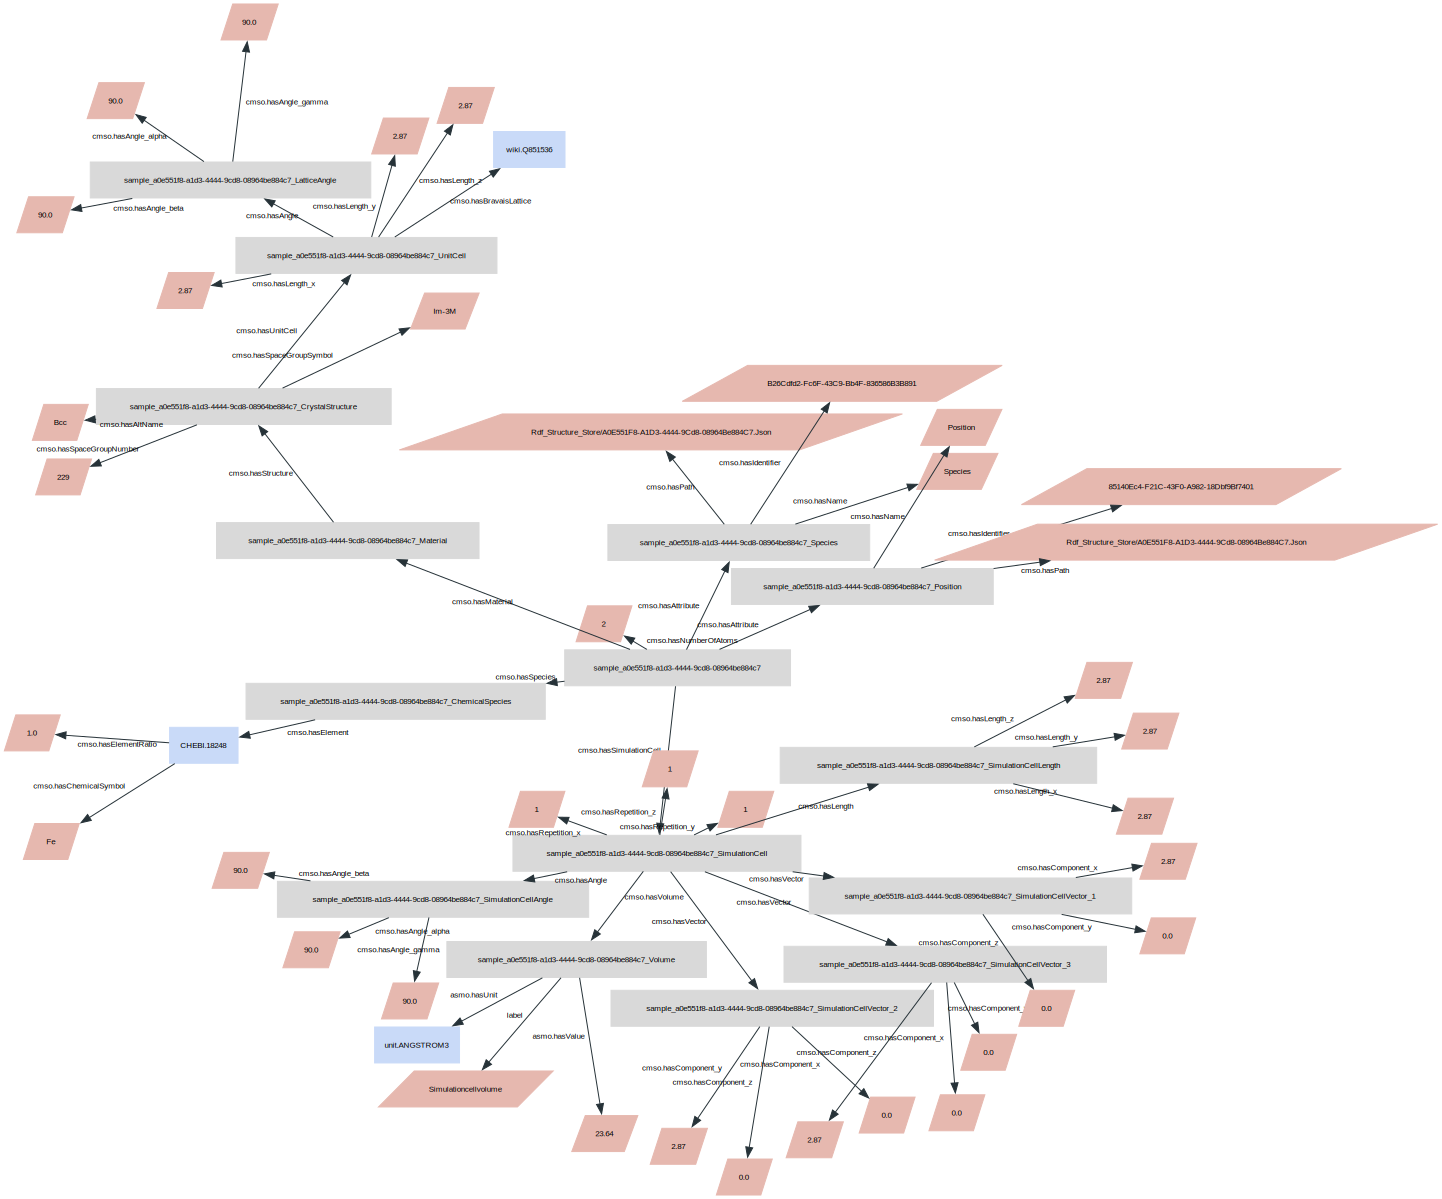

In [4]:
kg.visualise(hide_types=True)

Now a Si diamond structure

In [6]:
struct_Si = build.bulk("Si", graph=kg)

Finally, an L12 $Ni_3 Al$ structure

In [7]:
struct_l12 = build.bulk(['Al', 'Ni'], structure="l12", 
                         lattice_constant=3.57, graph=kg)

TypeError: unhashable type: 'list'

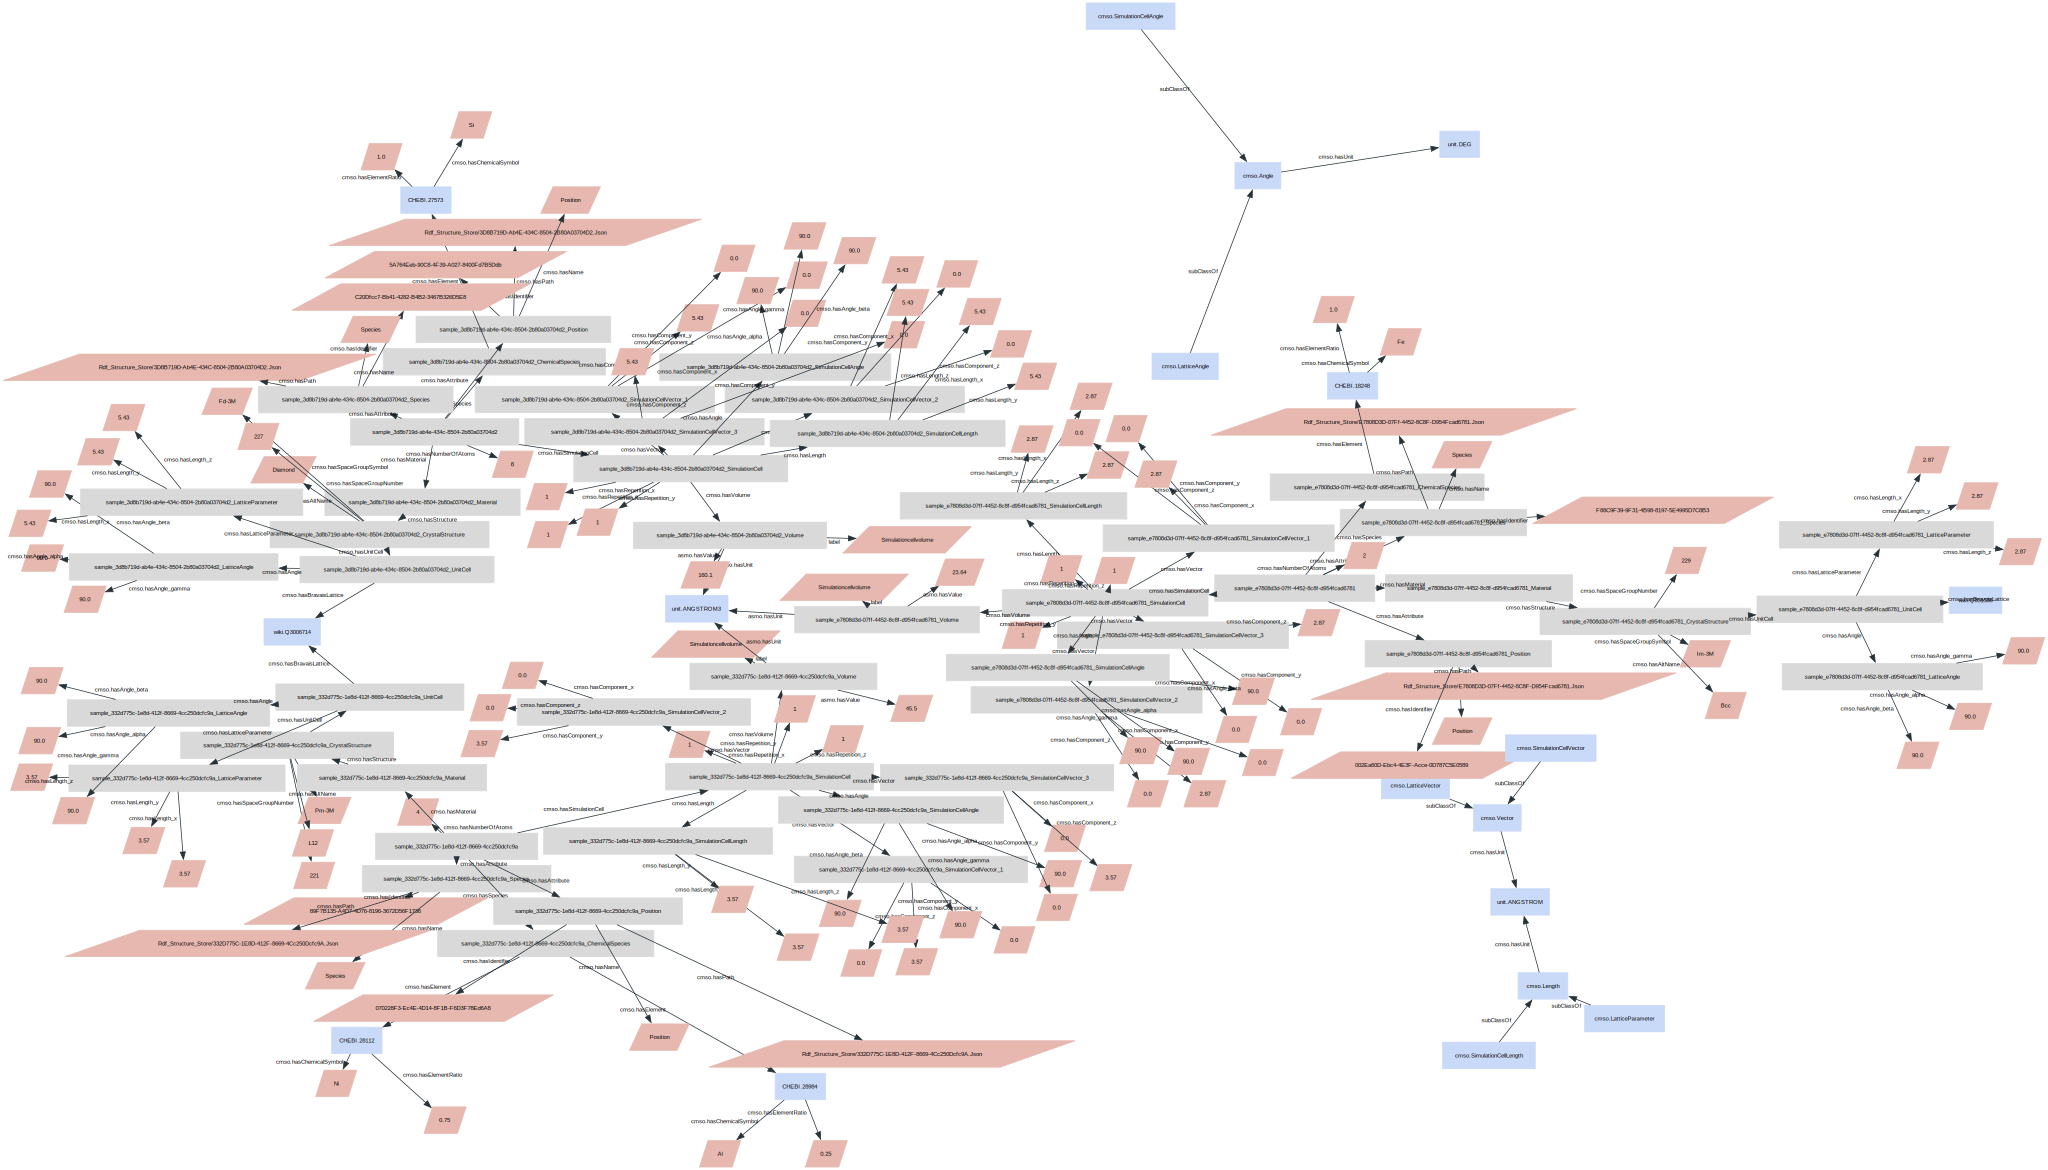

In [7]:
kg.visualise(hide_types=True, size=(60,30))

We can save the graph and reload it as needed

In [8]:
kg.write('serial.ttl', format='ttl')

In [9]:
kg = KnowledgeGraph(graph_file='serial.ttl')

In [10]:
kg.n_samples

3

## Querying the graph

An example question would be, **what are the space group of all structures with 4 atoms?**


The corresponding SPARQL query looks like this:

In [11]:
query = """
PREFIX cmso: <http://purls.helmholtz-metadaten.de/cmso/>
SELECT DISTINCT ?symbol
WHERE {
    ?sample cmso:hasNumberOfAtoms ?number .
    ?sample cmso:hasMaterial ?material .
    ?material cmso:hasStructure ?structure .
    ?structure cmso:hasSpaceGroupSymbol ?symbol .
FILTER (?number="4"^^xsd:integer)
}"""

In [12]:
res = kg.query(query)

And print the results

In [13]:
res

,symbol
0,Pm-3m


The query system can also be used without experience in SPARQL, or deep knowledge about the ontology terms. The same query would be:

In [ ]:
kg.query_sample([kg.terms.cmso.hasSpaceGroupSymbol, kg.terms.cmso.hasNumberOfAtoms==4])

,AtomicScaleSample,hasSpaceGroupSymbolvalue,hasNumberOfAtomsvalue
0,sample:12b94939-2c54-4bce-8179-c0ab184c6148,Pm-3m,4


Another one: **What are all the samples with Bravais lattice bcc?**. First how this looks like:

In [15]:
res = kg.query_sample( 
             [kg.ontology.terms.cmso.hasAltName=='bcc'])
res

,AtomicScaleSample,hasAltNamevalue
0,sample:f88a8dcf-11d0-4c65-9618-8c3b6e5dd9ee,bcc


As expected, there is only one sample, since Fe is the only bcc structure we added. We can extract the sample

In [16]:
sample = res.AtomicScaleSample[0]

We can write this sample to a file, for example, a LAMMPS data format, to use it for further simulations

In [17]:
kg.to_file(sample, 'bcc.data', format="lammps-data")

In [18]:
! more bcc.data

(written by ASE)

2 atoms
1 atom types

0.0      2.8700000000000001  xlo xhi
0.0      2.8700000000000001  ylo yhi
0.0      2.8700000000000001  zlo zhi

Atoms # atomic

     1   1                       0                       0                      
 0
     2   1      1.4350000000000001      1.4350000000000001      1.43500000000000
01


We can also export as an ASE object

In [19]:
aseobj = kg.to_file(sample, format="ase")

In [20]:
aseobj